In [1]:
!gdown --id 1gkUyLeI5ly1wBiXkdfGZDKQZLt3gcwCq

Downloading...
From: https://drive.google.com/uc?id=1gkUyLeI5ly1wBiXkdfGZDKQZLt3gcwCq
To: /content/LUMS_FALL2020_PROJECT_DATA.zip
802MB [00:05, 140MB/s]


In [2]:
!unzip LUMS_FALL2020_PROJECT_DATA.zip

Archive:  LUMS_FALL2020_PROJECT_DATA.zip
   creating: Gender_Recognition/Test/
   creating: Gender_Recognition/Test/SPK083_M/
  inflating: Gender_Recognition/Test/SPK083_M/1.wav  
  inflating: Gender_Recognition/Test/SPK083_M/10.wav  
  inflating: Gender_Recognition/Test/SPK083_M/2.wav  
  inflating: Gender_Recognition/Test/SPK083_M/3.wav  
  inflating: Gender_Recognition/Test/SPK083_M/4.wav  
  inflating: Gender_Recognition/Test/SPK083_M/5.wav  
  inflating: Gender_Recognition/Test/SPK083_M/6.wav  
  inflating: Gender_Recognition/Test/SPK083_M/7.wav  
  inflating: Gender_Recognition/Test/SPK083_M/8.wav  
  inflating: Gender_Recognition/Test/SPK083_M/9.wav  
   creating: Gender_Recognition/Test/SPK084_M/
  inflating: Gender_Recognition/Test/SPK084_M/1.wav  
  inflating: Gender_Recognition/Test/SPK084_M/10.wav  
  inflating: Gender_Recognition/Test/SPK084_M/2.wav  
  inflating: Gender_Recognition/Test/SPK084_M/3.wav  
  inflating: Gender_Recognition/Test/SPK084_M/4.wav  
  inflating: Ge

In [3]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=18998ad40b3d3091b3ca9235d4a33339098ba24a7344d944d23b9b468212641a
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [4]:
import os
import re
import string
import python_speech_features as mfcc
from scipy.io.wavfile import read
from glob import glob
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import random
from statistics import mode
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

## Multinomial Logistic Regression from Scratch

In [5]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [6]:
def read_file(path):
  stock_files=sorted(glob(path))
  corpus=[]
  for file_path in stock_files:
    sr, audio = read(file_path)
    features = get_MFCC(audio, sr)
    corpus.append(features)
  return corpus

In [7]:
def generate_data(path,path2):
  temp=read_file(path)
  temp2=read_file(path2)
  male=pd.DataFrame(temp)
  female=pd.DataFrame(temp2)
  male['Gender']=1
  female['Gender']=0
  final=pd.concat([male,female],ignore_index=True)
  labels=final['Gender']
  final.drop('Gender', inplace=True, axis=1)
  final=final.to_numpy()
  labels=labels.to_numpy()
  return final,labels

In [8]:
def read_file_multiclass(path):
  names = [os.path.basename(x) for x in glob(path)]
  stock_files=sorted(glob(path + '/*'))
  corpus=[]
  labels=[]
  for file_path in stock_files:
    check=re.split(r'/[0-9]|/10',file_path)
    check=re.split(r'/SPK',check[0])
    check=re.split(r'_M|_F',check[1])
    check=int(check[0])
    labels.append(check)
    sr, audio = read(file_path)
    features = get_MFCC(audio, sr)
    corpus.append(features)
  return corpus,labels

In [9]:
def generate_data_multiclass(path):
  feature,label=read_file_multiclass(path)
  df=pd.DataFrame(feature)
  labels=pd.DataFrame(label)
  df=df.to_numpy()
  labels=labels.to_numpy()
  labels.astype(int)
  return df,labels.flatten()

In [10]:
def oneHot(y):
  y_oneHot = (np.arange(np.max(y) + 1) == y[:, None]).astype(float)
  return y_oneHot

In [11]:
def softMax(z):
  return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [12]:
def predict(X, weights, biases):
  scores = (X.dot(weights) + biases)
  return softMax(scores)

In [13]:
def assignLabel(probability):
  return probability.argmax(axis=1)

In [14]:
def crossEntropy(X, y, weights, biases):
  y_pred = predict(X, weights, biases)
  return -np.sum(np.log(y_pred) * (y), axis=1)

In [15]:
def cost(X, y, weights, biases):
  return np.mean(crossEntropy(X, y, weights, biases))

In [16]:
def batchGradientDescent(n, X, y, weights, biases, alpha, n_epoch):
  m = X.shape[0]
  y = oneHot(y)
  J = list()
  for epoch in range(n_epoch):
    for j in np.arange(n):
      y_pred = predict(X, weights, biases)
      diff = np.subtract(y_pred[:,j],y[:,j])
      mul = np.multiply(X.T, diff)
      summ = np.sum(mul, axis = 1)
      theta = summ*alpha*(1/m)
      weights[:,j] = weights[:,j] - theta
      biases[:,j] = biases[:,j] - alpha*((np.sum(diff))*(1/m))
    J.append(cost(X,y,weights,biases))
  return weights, biases, J


In [17]:
def evaluation(predictions,true_labels):
  predicted_labels=predictions
  size=len(true_labels)
  indexes=['System Male','System Female']
  column=['Actual Male','Actual Female']
  k_1=pd.DataFrame(index=indexes,columns=column).fillna(0)
  for i in range(size):
    if predicted_labels[i] == true_labels[i]:
      if predicted_labels[i]==0:
        k_1['Actual Female']['System Female']+=1
      if predicted_labels[i]==1:
        k_1['Actual Male']['System Male']+=1
    if predicted_labels[i] != true_labels[i]:
      if predicted_labels[i]==0 and true_labels[i]==1:
        k_1['Actual Male']['System Female']+=1
      if predicted_labels[i]==1 and true_labels[i]==0:
        k_1['Actual Female']['System Male']+=1
  print(k_1)
  accuracy=(k_1['Actual Male']['System Male']+ k_1['Actual Female']['System Female'])/(k_1['Actual Male']['System Male']+ k_1['Actual Female']['System Female']+k_1['Actual Male']['System Female']+k_1['Actual Female']['System Male'])
  accuracy=accuracy*100
  precision=(k_1['Actual Male']['System Male'])/(k_1['Actual Male']['System Male']+k_1['Actual Female']['System Male'])
  recall=(k_1['Actual Male']['System Male'])/(k_1['Actual Male']['System Male']+k_1['Actual Male']['System Female'])
  Fscore=(2*precision*recall)/(precision+recall)
  print(f"\nAccuracy {accuracy:.2f}")
  print(f'Precision {(precision*100):.2f}')
  print(f'Recall {(recall*100):.2f}')
  print(f'F-1 Score {(Fscore*100):.2f}')

## Gender Classification

### Training

In [18]:
path='/content/Gender_Recognition/Train/*M/*'
path2='/content/Gender_Recognition/Train/*F/*'
X_train,y_train=generate_data(path,path2)

In [19]:
n_classes=2

In [20]:
weights = np.zeros((X_train.shape[1],n_classes), dtype= np.float64)
biases = np.zeros((1, n_classes), dtype= np.float64)

In [21]:
alpha = 0.01
n_epoch = 100

In [22]:
weights, biases, J = batchGradientDescent(n_classes, X_train, y_train, weights, biases, alpha, n_epoch)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Text(0.5, 1.0, 'Gender - Cost vs Epoch')

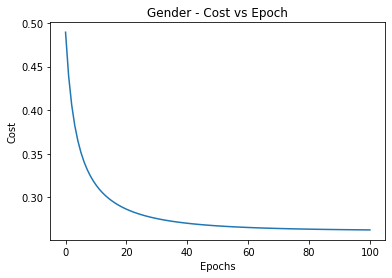

In [23]:
X=np.linspace(0, n_epoch, num=n_epoch)
J = np.array(J)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.plot(X, J)
plt.title('Gender - Cost vs Epoch')

###Validation

In [24]:
path='/content/Gender_Recognition/Valid/*M/*'
path2='/content/Gender_Recognition/Valid/*F/*'
X_valid,y_valid=generate_data(path,path2)

In [25]:
probabilities = predict(X_valid, weights, biases)

In [26]:
y_pred = assignLabel(probabilities)

In [27]:
print(evaluation(y_pred, y_valid))

               Actual Male  Actual Female
System Male            119             23
System Female           11             17

Accuracy 80.00
Precision 83.80
Recall 91.54
F-1 Score 87.50
None


###Testing

In [28]:
path='/content/Gender_Recognition/Test/*M/*'
path2='/content/Gender_Recognition/Test/*F/*'
X_test,y_test=generate_data(path,path2)

In [29]:
probabilities = predict(X_test, weights, biases)

In [30]:
y_pred = assignLabel(probabilities)

In [31]:
print(evaluation(y_pred, y_test))

               Actual Male  Actual Female
System Male            120             18
System Female           10             22

Accuracy 83.53
Precision 86.96
Recall 92.31
F-1 Score 89.55
None


## Speaker Recognition

### Training

In [32]:
path='/content/Speaker_Recognition/Train/*'
X_train,y_train=generate_data_multiclass(path)

In [33]:
n_classes = 143

In [34]:
weights = np.zeros((X_train.shape[1],n_classes), dtype= np.float64)
biases = np.zeros((1, n_classes), dtype= np.float64)

In [35]:
alpha = 0.01
n_epoch = 500

In [36]:
weights, biases, J = batchGradientDescent(n_classes, X_train, y_train, weights, biases, alpha, n_epoch)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Text(0.5, 1.0, 'Speaker - Cost vs Epoch')

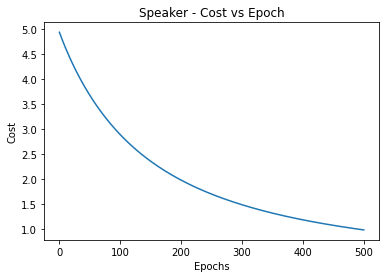

In [37]:
X=np.linspace(0, n_epoch, num=n_epoch)
J = np.array(J)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.plot(X, J)
plt.title('Speaker - Cost vs Epoch')

### Validation

In [38]:
path='/content/Speaker_Recognition/Valid/*'
X_valid,y_valid=generate_data_multiclass(path)

In [39]:
probabilities = predict(X_valid, weights, biases)

In [40]:
y_pred = assignLabel(probabilities)

In [41]:
report = classification_report(y_valid,y_pred)
f1 = f1_score(y_valid,y_pred, average='macro')
accuracy = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
print("\nClassification Report\n", report)
print("\nF1-Macro\n", f1)
print("\nAccuracy\n", accuracy)
print("\nConfusion Matrix\n", confusion)


Classification Report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00      0.50      0.67         2
   

### Testing

In [43]:
path='/content/Speaker_Recognition/Test/*'
X_test,y_test=generate_data_multiclass(path)

In [44]:
probabilities = predict(X_test, weights, biases)

In [45]:
y_pred = assignLabel(probabilities)

In [46]:
report = classification_report(y_test,y_pred)
f1 = f1_score(y_test,y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
print("\nClassification Report\n", report)
print("\nF1-Macro\n", f1)
print("\nAccuracy\n", accuracy)
print("\nConfusion Matrix\n", confusion)


Classification Report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       0.67      1.00      0.80         2
   